# App-3 : Nurse Scheduling (Planification des horaires infirmiers)

**Navigation** : [<< App-2 GraphColoring](App-2-GraphColoring.ipynb) | [Index](../README.md) | [App-4 JobShopScheduling >>](App-4-JobShopScheduling.ipynb)

## Objectifs d'apprentissage

A la fin de ce notebook, vous saurez :
1. **Modeliser** le Nurse Rostering Problem (NRP) comme un probleme de satisfaction de contraintes
2. **Distinguer** contraintes dures (obligatoires) et souples (preferences)
3. **Implementer** un modele CP-SAT complet avec OR-Tools
4. **Optimiser** un planning en minimisant les penalites (equilibre de charge, preferences)
5. **Visualiser** et analyser la qualite d'un planning infirmier

### Prerequis
- Python 3.10+
- Search-8 (CSP Advanced) : programmation par contraintes avec OR-Tools
- Notions de base sur les problemes d'optimisation combinatoire

### Duree estimee : 60 minutes

### Source
Adapte du projet etudiant EPITA PPC 2025 (Nurse Rostering Problem, jsboigeEpita/2025-PPC).

---

## 1. Introduction (~5 min)

Le **Nurse Rostering Problem** (NRP) consiste a affecter des equipes (shifts) a un ensemble d'infirmiers sur un horizon de planification, en respectant la reglementation du travail, les besoins en personnel et les preferences individuelles.

### Pourquoi ce probleme est important

| Aspect | Impact |
|--------|--------|
| **Sante** | Un planning mal concu entraine fatigue, erreurs medicales, burnout |
| **Reglementation** | Les lois du travail imposent des contraintes strictes (repos, duree max) |
| **Equite** | Les infirmiers doivent percevoir la repartition comme juste |
| **Complexite** | NP-hard des que l'on depasse quelques infirmiers et quelques jours |
| **Volume** | Des milliers d'hopitaux doivent resoudre ce probleme chaque mois |

### Approche

Nous allons progresser en trois etapes :
1. **Modele de base** : 5 infirmiers, 7 jours, contraintes dures uniquement
2. **Optimisation** : ajout de contraintes souples (equilibre, preferences) avec fonction objectif
3. **Passage a l'echelle** : 15 infirmiers, 28 jours, parametres avances du solveur

### Installation et imports

Nous utilisons **OR-Tools** de Google, la bibliotheque de reference pour la programmation par contraintes et l'optimisation. Le solveur CP-SAT est particulierement adapte aux problemes de planification.

In [1]:
# Installation si necessaire
# !pip install ortools matplotlib numpy

import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ortools.sat.python import cp_model

# Helpers partages de la serie Search
sys.path.insert(0, '..')
from search_helpers import benchmark_table

print(f"OR-Tools version : {cp_model.__name__}")
print("Imports OK")

OR-Tools version : ortools.sat.python.cp_model
Imports OK


---

## 2. Formulation du probleme (~8 min)

### Donnees du probleme

Nous commencons par un cas de taille modeste pour bien comprendre la modelisation.

| Parametre | Valeur |
|-----------|--------|
| Infirmiers | 5 (Alice, Bob, Claire, David, Emma) |
| Jours | 7 (lundi a dimanche) |
| Equipes (shifts) | 3 : Matin (M), Apres-midi (A), Nuit (N) |
| Besoin par shift | Exactement 1 infirmier par shift par jour |

### Variables de decision

Pour chaque triplet (infirmier $n$, jour $d$, shift $s$), on definit une variable booleenne :

$$x_{n,d,s} \in \{0, 1\}$$

ou $x_{n,d,s} = 1$ signifie que l'infirmier $n$ travaille le shift $s$ le jour $d$.

**Taille de l'espace** : $2^{5 \times 7 \times 3} = 2^{105} \approx 4 \times 10^{31}$ combinaisons possibles.

### Contraintes dures (obligatoires)

| # | Contrainte | Formulation |
|---|------------|-------------|
| C1 | **Couverture** | Chaque shift de chaque jour doit etre assure par exactement 1 infirmier : $\sum_n x_{n,d,s} = 1$ |
| C2 | **Unicite** | Un infirmier ne peut pas travailler 2 shifts le meme jour : $\sum_s x_{n,d,s} \leq 1$ |
| C3 | **Repos** | Pas de shift Matin apres un shift Nuit (repos obligatoire) |
| C4 | **Charge max** | Maximum 5 shifts par semaine par infirmier : $\sum_{d,s} x_{n,d,s} \leq 5$ |

### Contraintes souples (a optimiser)

| # | Contrainte | Objectif |
|---|------------|----------|
| S1 | **Equilibre de charge** | Minimiser l'ecart de nombre de shifts entre infirmiers |
| S2 | **Preferences** | Respecter les preferences individuelles (ex : pas de weekend) |

### Definition des donnees

Definissons les constantes du probleme et les preferences des infirmiers.

In [2]:
# --- Donnees du probleme ---

# Infirmiers
nurses = ['Alice', 'Bob', 'Claire', 'David', 'Emma']
num_nurses = len(nurses)

# Jours de la semaine
days = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim']
num_days = len(days)

# Shifts (equipes)
shifts = ['Matin', 'Apres-midi', 'Nuit']
num_shifts = len(shifts)

# Indices pour faciliter la modelisation
MATIN = 0
APRES_MIDI = 1
NUIT = 2

# Jours du weekend
weekend_days = [5, 6]  # Samedi, Dimanche

# Preferences des infirmiers (jours/shifts non desires)
# Format : {nurse_index: [(day_index, shift_index), ...]}
preferences = {
    0: [(5, MATIN), (5, APRES_MIDI), (6, MATIN), (6, APRES_MIDI)],  # Alice : pas de weekend jour
    1: [(0, NUIT), (1, NUIT), (2, NUIT)],  # Bob : pas de nuits en debut de semaine
    2: [],  # Claire : pas de preference particuliere
    3: [(4, MATIN), (4, APRES_MIDI), (4, NUIT)],  # David : prefere ne pas travailler vendredi
    4: [(6, NUIT)],  # Emma : pas de nuit le dimanche
}

# Penalite pour chaque preference non respectee
preference_penalty = 2

# Besoin par shift par jour (1 infirmier par shift)
demand = 1

# Charge maximale par semaine
max_shifts_per_week = 5

# Affichage
print("Donnees du probleme")
print("=" * 50)
print(f"Infirmiers       : {num_nurses} ({', '.join(nurses)})")
print(f"Jours            : {num_days} ({', '.join(days)})")
print(f"Shifts/jour      : {num_shifts} ({', '.join(shifts)})")
print(f"Slots a couvrir  : {num_days * num_shifts}")
print(f"Variables bool   : {num_nurses * num_days * num_shifts}")
print(f"Espace brut      : 2^{num_nurses * num_days * num_shifts}")
print(f"Charge max/sem   : {max_shifts_per_week} shifts")
print(f"\nPreferences :")
for n in range(num_nurses):
    prefs = preferences[n]
    if prefs:
        pref_str = ', '.join(f"{days[d]}-{shifts[s]}" for d, s in prefs)
        print(f"  {nurses[n]:>8} : eviter {pref_str}")
    else:
        print(f"  {nurses[n]:>8} : aucune preference")

Donnees du probleme
Infirmiers       : 5 (Alice, Bob, Claire, David, Emma)
Jours            : 7 (Lun, Mar, Mer, Jeu, Ven, Sam, Dim)
Shifts/jour      : 3 (Matin, Apres-midi, Nuit)
Slots a couvrir  : 21
Variables bool   : 105
Espace brut      : 2^105
Charge max/sem   : 5 shifts

Preferences :
     Alice : eviter Sam-Matin, Sam-Apres-midi, Dim-Matin, Dim-Apres-midi
       Bob : eviter Lun-Nuit, Mar-Nuit, Mer-Nuit
    Claire : aucune preference
     David : eviter Ven-Matin, Ven-Apres-midi, Ven-Nuit
      Emma : eviter Dim-Nuit


---

## 3. Modele CP-SAT - Contraintes dures (~12 min)

Nous construisons le modele CP-SAT etape par etape. Le solveur CP-SAT d'OR-Tools est un solveur de programmation par contraintes base sur la satisfiabilite (SAT). Il est particulierement efficace pour les problemes de planification.

### Etape 1 : creation des variables

Pour chaque combinaison (infirmier, jour, shift), on cree une variable booleenne.

In [3]:
# --- Construction du modele CP-SAT ---

model = cp_model.CpModel()

# Variables de decision : x[n][d][s] = 1 si infirmier n travaille le shift s le jour d
x = {}
for n in range(num_nurses):
    for d in range(num_days):
        for s in range(num_shifts):
            x[(n, d, s)] = model.new_bool_var(f'x_{nurses[n]}_{days[d]}_{shifts[s]}')

print(f"Variables creees : {len(x)} variables booleennes")
print(f"Exemple : x[(0, 0, 0)] = '{x[(0, 0, 0)]}' (Alice, Lundi, Matin)")

Variables creees : 105 variables booleennes
Exemple : x[(0, 0, 0)] = 'x_Alice_Lun_Matin' (Alice, Lundi, Matin)


### Etape 2 : contrainte de couverture (C1)

Chaque shift de chaque jour doit etre assure par exactement 1 infirmier :

$$\forall d \in \text{Jours}, \forall s \in \text{Shifts} : \sum_{n=1}^{N} x_{n,d,s} = 1$$

In [4]:
# C1 : Couverture - exactement 1 infirmier par shift par jour
num_coverage = 0
for d in range(num_days):
    for s in range(num_shifts):
        model.add(sum(x[(n, d, s)] for n in range(num_nurses)) == demand)
        num_coverage += 1

print(f"C1 - Contraintes de couverture : {num_coverage}")

C1 - Contraintes de couverture : 21


### Etape 3 : contrainte d'unicite (C2)

Un infirmier ne peut travailler qu'un seul shift par jour (ou aucun) :

$$\forall n \in \text{Infirmiers}, \forall d \in \text{Jours} : \sum_{s=1}^{S} x_{n,d,s} \leq 1$$

In [5]:
# C2 : Unicite - au plus 1 shift par jour par infirmier
num_unique = 0
for n in range(num_nurses):
    for d in range(num_days):
        model.add(sum(x[(n, d, s)] for s in range(num_shifts)) <= 1)
        num_unique += 1

print(f"C2 - Contraintes d'unicite : {num_unique}")

C2 - Contraintes d'unicite : 35


### Etape 4 : contrainte de repos (C3)

Apres un shift de nuit, l'infirmier ne peut pas travailler le matin du jour suivant (repos obligatoire d'au moins 8h) :

$$\forall n, \forall d < D-1 : x_{n,d,\text{Nuit}} + x_{n,d+1,\text{Matin}} \leq 1$$

Cela signifie que les deux variables ne peuvent pas etre simultanement a 1.

In [6]:
# C3 : Repos - pas de Matin apres une Nuit
num_rest = 0
for n in range(num_nurses):
    for d in range(num_days - 1):
        # Nuit du jour d incompatible avec Matin du jour d+1
        model.add(x[(n, d, NUIT)] + x[(n, d + 1, MATIN)] <= 1)
        num_rest += 1

print(f"C3 - Contraintes de repos : {num_rest}")

C3 - Contraintes de repos : 30


### Etape 5 : contrainte de charge maximale (C4)

Chaque infirmier travaille au maximum 5 shifts par semaine :

$$\forall n : \sum_{d,s} x_{n,d,s} \leq 5$$

In [7]:
# C4 : Charge maximale - au plus 5 shifts par semaine
num_maxload = 0
for n in range(num_nurses):
    total_shifts = sum(x[(n, d, s)] for d in range(num_days) for s in range(num_shifts))
    model.add(total_shifts <= max_shifts_per_week)
    num_maxload += 1

print(f"C4 - Contraintes de charge max : {num_maxload}")

# Resume des contraintes
print(f"\nResume du modele (contraintes dures)")
print("=" * 45)
print(f"Variables         : {len(x)}")
print(f"C1 (couverture)   : {num_coverage}")
print(f"C2 (unicite)      : {num_unique}")
print(f"C3 (repos)        : {num_rest}")
print(f"C4 (charge max)   : {num_maxload}")
print(f"Total contraintes : {num_coverage + num_unique + num_rest + num_maxload}")

C4 - Contraintes de charge max : 5

Resume du modele (contraintes dures)
Variables         : 105
C1 (couverture)   : 21
C2 (unicite)      : 35
C3 (repos)        : 30
C4 (charge max)   : 5
Total contraintes : 91


### Resolution et affichage du planning

Resolvons le modele avec les contraintes dures uniquement (sans optimisation). Le solveur CP-SAT va chercher une solution faisable.

In [8]:
# --- Resolution (contraintes dures uniquement) ---

solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 10.0

start_time = time.time()
status = solver.solve(model)
solve_time = (time.time() - start_time) * 1000

status_names = {
    cp_model.OPTIMAL: 'OPTIMAL',
    cp_model.FEASIBLE: 'FEASIBLE',
    cp_model.INFEASIBLE: 'INFEASIBLE',
    cp_model.MODEL_INVALID: 'MODEL_INVALID',
    cp_model.UNKNOWN: 'UNKNOWN',
}

print(f"Statut : {status_names.get(status, 'INCONNU')}")
print(f"Temps  : {solve_time:.1f} ms")

Statut : OPTIMAL
Temps  : 46.8 ms


Definissons une fonction utilitaire pour afficher le planning sous forme de tableau, puis affichons la solution trouvee.

In [9]:
def display_schedule(solver, x, nurses, days, shifts, num_nurses, num_days, num_shifts):
    """Affiche le planning sous forme de tableau texte."""
    # En-tete
    header = f"{'Infirmier':<12}" + ''.join(f"{d:>8}" for d in days)
    print(header)
    print("-" * len(header))

    # Corps du tableau
    shift_counts = {}
    for n in range(num_nurses):
        row = f"{nurses[n]:<12}"
        count = 0
        for d in range(num_days):
            assigned = '-'
            for s in range(num_shifts):
                if solver.value(x[(n, d, s)]) == 1:
                    assigned = shifts[s][0]  # M, A, N
                    count += 1
            row += f"{assigned:>8}"
        row += f"  | {count} shifts"
        print(row)
        shift_counts[nurses[n]] = count

    return shift_counts


if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    print("\nPlanning (contraintes dures uniquement)")
    print("=" * 80)
    print("Legende : M = Matin, A = Apres-midi, N = Nuit, - = Repos")
    print()
    shift_counts_hard = display_schedule(
        solver, x, nurses, days, shifts, num_nurses, num_days, num_shifts
    )
else:
    print("Aucune solution trouvee !")


Planning (contraintes dures uniquement)
Legende : M = Matin, A = Apres-midi, N = Nuit, - = Repos

Infirmier        Lun     Mar     Mer     Jeu     Ven     Sam     Dim
--------------------------------------------------------------------
Alice              N       A       -       M       A       N       -  | 5 shifts
Bob                A       N       N       -       -       M       A  | 5 shifts
Claire             -       -       A       A       M       -       M  | 4 shifts
David              -       -       -       -       N       A       N  | 3 shifts
Emma               M       M       M       N       -       -       -  | 4 shifts


### Interpretation : modele avec contraintes dures

**Sortie obtenue** : le solveur trouve un planning faisable qui respecte toutes les contraintes obligatoires.

| Contrainte | Verifiee | Comment |
|------------|----------|----------|
| C1 (couverture) | Oui | Chaque colonne-shift a exactement 1 lettre M, A ou N |
| C2 (unicite) | Oui | Chaque infirmier a au plus 1 lettre par jour |
| C3 (repos) | Oui | Aucun M n'apparait le lendemain d'un N |
| C4 (charge max) | Oui | Aucun infirmier ne depasse 5 shifts |

**Points cles** :
1. Le planning est **faisable** mais pas necessairement **equitable** : certains infirmiers peuvent avoir beaucoup plus de shifts que d'autres
2. Les **preferences** individuelles ne sont pas prises en compte
3. Le solveur trouve la premiere solution faisable, sans chercher a optimiser

> **Question** : comment rendre le planning plus equitable et respectueux des preferences ? C'est le role des contraintes souples.

---

## 4. Ajout des contraintes souples (~10 min)

Les contraintes souples ne sont pas obligatoires, mais on souhaite les satisfaire autant que possible. On les modelise comme des **penalites** dans une fonction objectif a minimiser.

### Strategie d'optimisation

$$\text{Minimiser } Z = w_1 \cdot P_{\text{equilibre}} + w_2 \cdot P_{\text{preferences}}$$

| Penalite | Formulation | Poids |
|----------|-------------|-------|
| $P_{\text{equilibre}}$ | Difference entre charge max et charge min parmi tous les infirmiers | $w_1 = 10$ |
| $P_{\text{preferences}}$ | Nombre de preferences non respectees | $w_2 = 2$ |

### Penalite d'equilibre de charge

Pour mesurer le desequilibre, on utilise la difference entre la charge maximale et la charge minimale :

$$P_{\text{equilibre}} = \max_n \left(\sum_{d,s} x_{n,d,s}\right) - \min_n \left(\sum_{d,s} x_{n,d,s}\right)$$

En CP-SAT, on ne peut pas utiliser directement `max` et `min` sur des expressions. On utilise des **variables auxiliaires** avec `add_max_equality` et `add_min_equality`.

In [10]:
# --- Nouveau modele avec contraintes dures + souples ---

model_opt = cp_model.CpModel()

# Variables de decision (meme structure)
x_opt = {}
for n in range(num_nurses):
    for d in range(num_days):
        for s in range(num_shifts):
            x_opt[(n, d, s)] = model_opt.new_bool_var(f'x_{nurses[n]}_{days[d]}_{shifts[s]}')

# --- Contraintes dures (identiques) ---

# C1 : Couverture
for d in range(num_days):
    for s in range(num_shifts):
        model_opt.add(sum(x_opt[(n, d, s)] for n in range(num_nurses)) == demand)

# C2 : Unicite
for n in range(num_nurses):
    for d in range(num_days):
        model_opt.add(sum(x_opt[(n, d, s)] for s in range(num_shifts)) <= 1)

# C3 : Repos
for n in range(num_nurses):
    for d in range(num_days - 1):
        model_opt.add(x_opt[(n, d, NUIT)] + x_opt[(n, d + 1, MATIN)] <= 1)

# C4 : Charge max
for n in range(num_nurses):
    total = sum(x_opt[(n, d, s)] for d in range(num_days) for s in range(num_shifts))
    model_opt.add(total <= max_shifts_per_week)

print("Contraintes dures ajoutees.")

# --- Contraintes souples ---

# S1 : Equilibre de charge
# Variable pour le nombre total de shifts de chaque infirmier
nurse_totals = []
for n in range(num_nurses):
    total_n = model_opt.new_int_var(0, max_shifts_per_week, f'total_{nurses[n]}')
    model_opt.add(total_n == sum(x_opt[(n, d, s)]
                                 for d in range(num_days)
                                 for s in range(num_shifts)))
    nurse_totals.append(total_n)

# Variables auxiliaires pour max et min
max_total = model_opt.new_int_var(0, max_shifts_per_week, 'max_total')
min_total = model_opt.new_int_var(0, max_shifts_per_week, 'min_total')
model_opt.add_max_equality(max_total, nurse_totals)
model_opt.add_min_equality(min_total, nurse_totals)

# Ecart = max - min
balance_penalty = model_opt.new_int_var(0, max_shifts_per_week, 'balance_penalty')
model_opt.add(balance_penalty == max_total - min_total)

print("S1 : Penalite d'equilibre ajoutee.")

# S2 : Preferences
# Pour chaque preference non respectee, on ajoute une penalite
pref_violations = []
for n in range(num_nurses):
    for (d, s) in preferences[n]:
        # x_opt[(n, d, s)] = 1 signifie que la preference est violee
        pref_violations.append(x_opt[(n, d, s)])

total_pref_penalty = model_opt.new_int_var(0, len(pref_violations), 'total_pref_penalty')
if pref_violations:
    model_opt.add(total_pref_penalty == sum(pref_violations))
else:
    model_opt.add(total_pref_penalty == 0)

print(f"S2 : {len(pref_violations)} preferences modelisees.")

# --- Fonction objectif ---
weight_balance = 10
weight_prefs = preference_penalty

objective = weight_balance * balance_penalty + weight_prefs * total_pref_penalty
model_opt.minimize(objective)

print(f"\nFonction objectif : Minimize({weight_balance} * ecart_charge + {weight_prefs} * violations_prefs)")

Contraintes dures ajoutees.
S1 : Penalite d'equilibre ajoutee.
S2 : 11 preferences modelisees.

Fonction objectif : Minimize(10 * ecart_charge + 2 * violations_prefs)


### Resolution avec optimisation

Le solveur va maintenant chercher la solution qui minimise la penalite totale, tout en respectant toutes les contraintes dures.

In [11]:
# --- Resolution du modele optimise ---

solver_opt = cp_model.CpSolver()
solver_opt.parameters.max_time_in_seconds = 10.0

start_time = time.time()
status_opt = solver_opt.solve(model_opt)
solve_time_opt = (time.time() - start_time) * 1000

print(f"Statut : {status_names.get(status_opt, 'INCONNU')}")
print(f"Temps  : {solve_time_opt:.1f} ms")

if status_opt in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    obj_value = solver_opt.objective_value
    balance_val = solver_opt.value(balance_penalty)
    pref_val = solver_opt.value(total_pref_penalty)

    print(f"\nObjectif total         : {obj_value}")
    print(f"Ecart de charge (S1)   : {balance_val} (penalite : {weight_balance * balance_val})")
    print(f"Preferences violees (S2): {pref_val} / {len(pref_violations)} "
          f"(penalite : {weight_prefs * pref_val})")

    print(f"\nPlanning optimise")
    print("=" * 80)
    print("Legende : M = Matin, A = Apres-midi, N = Nuit, - = Repos")
    print()
    shift_counts_opt = display_schedule(
        solver_opt, x_opt, nurses, days, shifts, num_nurses, num_days, num_shifts
    )

Statut : OPTIMAL
Temps  : 43.0 ms

Objectif total         : 10.0
Ecart de charge (S1)   : 1 (penalite : 10)
Preferences violees (S2): 0 / 11 (penalite : 0)

Planning optimise
Legende : M = Matin, A = Apres-midi, N = Nuit, - = Repos

Infirmier        Lun     Mar     Mer     Jeu     Ven     Sam     Dim
--------------------------------------------------------------------
Alice              -       -       A       M       N       N       -  | 4 shifts
Bob                M       M       M       -       -       -       M  | 4 shifts
Claire             -       -       N       A       A       -       A  | 4 shifts
David              N       N       -       N       -       M       N  | 5 shifts
Emma               A       A       -       -       M       A       -  | 4 shifts


### Interpretation : modele avec contraintes souples

**Sortie obtenue** : le solveur trouve un planning optimal qui minimise les penalites.

| Aspect | Sans optimisation | Avec optimisation |
|--------|-------------------|-------------------|
| Contraintes dures | Toutes respectees | Toutes respectees |
| Equilibre de charge | Non garanti | Ecart minimise |
| Preferences | Non prises en compte | Maximalement respectees |

**Points cles** :
1. L'ecart de charge entre l'infirmier le plus et le moins charge est minimise
2. Les preferences sont respectees autant que possible, dans la limite des contraintes dures
3. Il y a un **compromis** entre equilibre et preferences : on ne peut pas toujours satisfaire les deux parfaitement

> **Note technique** : les poids $w_1 = 10$ et $w_2 = 2$ refletent l'importance relative de l'equilibre par rapport aux preferences. Ajuster ces poids change le compromis.

### Comparaison des deux plannings

Comparons visuellement les plannings avec et sans optimisation.

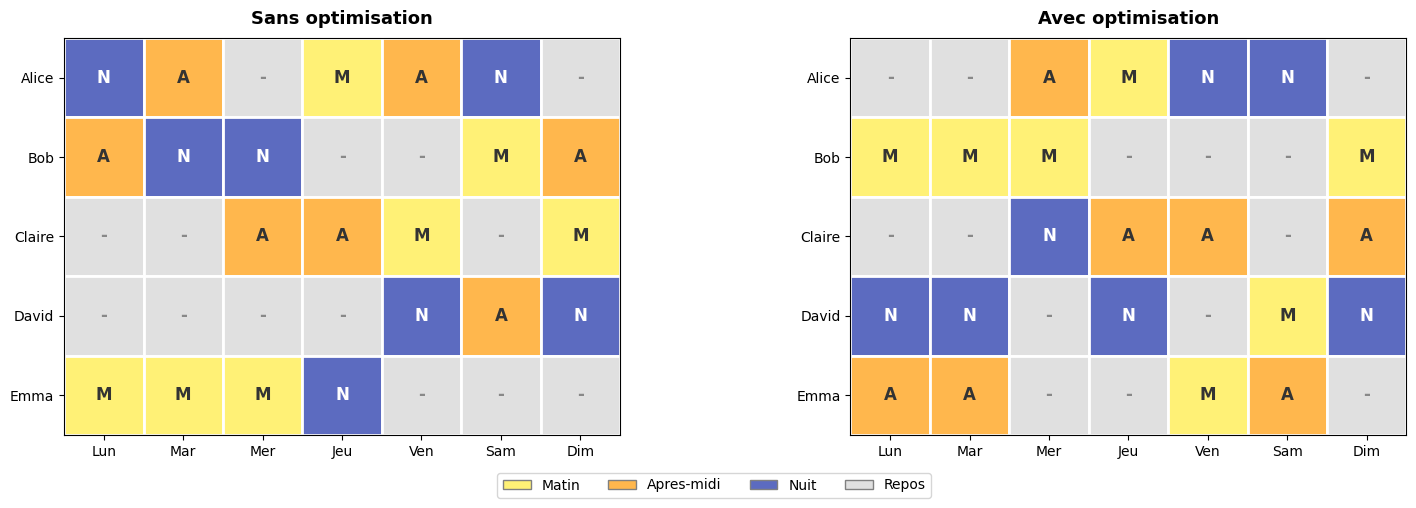

In [12]:
def schedule_to_matrix(solver_instance, x_vars, num_nurses, num_days, num_shifts):
    """Convertit la solution en matrice (nurse x day) avec valeur de shift.
    Valeurs : -1 = repos, 0 = Matin, 1 = Apres-midi, 2 = Nuit.
    """
    matrix = np.full((num_nurses, num_days), -1)
    for n in range(num_nurses):
        for d in range(num_days):
            for s in range(num_shifts):
                if solver_instance.value(x_vars[(n, d, s)]) == 1:
                    matrix[n, d] = s
    return matrix


def plot_schedule_heatmap(matrix, nurses, days, shifts, title, ax):
    """Affiche un planning sous forme de grille coloree."""
    # Couleurs : gris = repos, jaune = Matin, orange = Apres-midi, bleu fonce = Nuit
    colors_map = {
        -1: '#E0E0E0',  # Repos
        0: '#FFF176',   # Matin
        1: '#FFB74D',   # Apres-midi
        2: '#5C6BC0',   # Nuit
    }
    text_colors = {
        -1: '#888888',
        0: '#333333',
        1: '#333333',
        2: '#FFFFFF',
    }
    labels = {-1: '-', 0: 'M', 1: 'A', 2: 'N'}

    n_rows, n_cols = matrix.shape
    for i in range(n_rows):
        for j in range(n_cols):
            val = int(matrix[i, j])
            rect = plt.Rectangle((j, n_rows - 1 - i), 1, 1,
                                 facecolor=colors_map[val],
                                 edgecolor='white', linewidth=2)
            ax.add_patch(rect)
            ax.text(j + 0.5, n_rows - 1 - i + 0.5, labels[val],
                    ha='center', va='center', fontsize=12, fontweight='bold',
                    color=text_colors[val])

    ax.set_xlim(0, n_cols)
    ax.set_ylim(0, n_rows)
    ax.set_xticks([j + 0.5 for j in range(n_cols)])
    ax.set_xticklabels(days, fontsize=10)
    ax.set_yticks([i + 0.5 for i in range(n_rows)])
    ax.set_yticklabels(list(reversed(nurses)), fontsize=10)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=13, fontweight='bold', pad=10)


# Construire les matrices
matrix_hard = schedule_to_matrix(solver, x, num_nurses, num_days, num_shifts)
matrix_opt = schedule_to_matrix(solver_opt, x_opt, num_nurses, num_days, num_shifts)

# Visualisation cote a cote
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_schedule_heatmap(matrix_hard, nurses, days, shifts,
                      'Sans optimisation', axes[0])
plot_schedule_heatmap(matrix_opt, nurses, days, shifts,
                      'Avec optimisation', axes[1])

# Legende commune
legend_elements = [
    mpatches.Patch(facecolor='#FFF176', edgecolor='gray', label='Matin'),
    mpatches.Patch(facecolor='#FFB74D', edgecolor='gray', label='Apres-midi'),
    mpatches.Patch(facecolor='#5C6BC0', edgecolor='gray', label='Nuit'),
    mpatches.Patch(facecolor='#E0E0E0', edgecolor='gray', label='Repos'),
]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, fontsize=10,
           bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
plt.subplots_adjust(bottom=0.12)
plt.show()

### Interpretation : comparaison visuelle

**Sortie obtenue** : les deux grilles montrent la difference entre un planning faisable (a gauche) et un planning optimise (a droite).

**Points cles** :
1. **Equilibre** : dans le planning optimise, les shifts sont mieux repartis (colonnes de droite du tableau plus uniformes)
2. **Preferences** : le planning optimise evite autant que possible les creneaux non desires
3. **Nuits** : la contrainte de repos (pas de M apres N) est visible dans les deux grilles

> **Note** : la difference peut paraitre subtile sur 5 infirmiers / 7 jours. L'impact de l'optimisation devient bien plus visible a plus grande echelle.

---

## 5. Passage a l'echelle (~8 min)

Testons la capacite du solveur CP-SAT sur un probleme plus realiste :

| Parametre | Valeur |
|-----------|--------|
| Infirmiers | 15 |
| Jours | 28 (4 semaines) |
| Shifts/jour | 3 |
| Variables | $15 \times 28 \times 3 = 1260$ |
| Espace brut | $2^{1260}$ |

### Contraintes supplementaires

En plus des contraintes C1-C4, nous ajoutons :
- **C5** : chaque infirmier a au moins 1 weekend complet de repos sur 4
- **C6** : au moins 2 infirmiers par shift (demande accrue)

### Solution callback

Pour observer la progression du solveur, on utilise un **callback** qui enregistre chaque solution ameliorante trouvee.

In [13]:
# --- Probleme a grande echelle ---

num_nurses_lg = 15
num_days_lg = 28
num_shifts_lg = 3
num_weeks = 4
demand_lg = 2  # 2 infirmiers par shift
max_shifts_per_week_lg = 5

nurses_lg = [f'Inf_{i+1:02d}' for i in range(num_nurses_lg)]
days_lg = [f'J{d+1:02d}' for d in range(num_days_lg)]

# Generer des preferences aleatoires (2-3 par infirmier)
rng = np.random.RandomState(42)
preferences_lg = {}
for n in range(num_nurses_lg):
    n_prefs = rng.randint(2, 5)
    prefs = set()
    while len(prefs) < n_prefs:
        d = rng.randint(0, num_days_lg)
        s = rng.randint(0, num_shifts_lg)
        prefs.add((d, s))
    preferences_lg[n] = list(prefs)

print(f"Probleme a grande echelle")
print("=" * 45)
print(f"Infirmiers    : {num_nurses_lg}")
print(f"Jours         : {num_days_lg} ({num_weeks} semaines)")
print(f"Shifts/jour   : {num_shifts_lg}")
print(f"Demande/shift : {demand_lg} infirmiers")
print(f"Variables     : {num_nurses_lg * num_days_lg * num_shifts_lg}")
print(f"Preferences   : {sum(len(v) for v in preferences_lg.values())} au total")

Probleme a grande echelle
Infirmiers    : 15
Jours         : 28 (4 semaines)
Shifts/jour   : 3
Demande/shift : 2 infirmiers
Variables     : 1260
Preferences   : 43 au total


Construisons maintenant le modele CP-SAT pour ce probleme plus grand, avec les contraintes supplementaires C5 (weekend de repos) et la demande accrue (2 infirmiers par shift).

In [14]:
# --- Construction du modele a grande echelle ---

model_lg = cp_model.CpModel()

# Variables
x_lg = {}
for n in range(num_nurses_lg):
    for d in range(num_days_lg):
        for s in range(num_shifts_lg):
            x_lg[(n, d, s)] = model_lg.new_bool_var(f'x_{n}_{d}_{s}')

# C1 : Couverture (2 infirmiers par shift)
for d in range(num_days_lg):
    for s in range(num_shifts_lg):
        model_lg.add(sum(x_lg[(n, d, s)] for n in range(num_nurses_lg)) == demand_lg)

# C2 : Unicite
for n in range(num_nurses_lg):
    for d in range(num_days_lg):
        model_lg.add(sum(x_lg[(n, d, s)] for s in range(num_shifts_lg)) <= 1)

# C3 : Repos (pas de Matin apres une Nuit)
for n in range(num_nurses_lg):
    for d in range(num_days_lg - 1):
        model_lg.add(x_lg[(n, d, NUIT)] + x_lg[(n, d + 1, MATIN)] <= 1)

# C4 : Charge max par semaine
for n in range(num_nurses_lg):
    for w in range(num_weeks):
        week_start = w * 7
        week_shifts = sum(x_lg[(n, d, s)]
                         for d in range(week_start, week_start + 7)
                         for s in range(num_shifts_lg))
        model_lg.add(week_shifts <= max_shifts_per_week_lg)

# C5 : Au moins 1 weekend complet de repos sur 4
for n in range(num_nurses_lg):
    weekend_free = []
    for w in range(num_weeks):
        sat = w * 7 + 5
        sun = w * 7 + 6
        # Variable booleenne : 1 si ce weekend est libre
        is_free = model_lg.new_bool_var(f'wkend_free_{n}_{w}')
        # Un weekend est libre si aucun shift le samedi ni le dimanche
        weekend_shifts = [x_lg[(n, sat, s)] for s in range(num_shifts_lg)] + \
                         [x_lg[(n, sun, s)] for s in range(num_shifts_lg)]
        # is_free = 1 => tous les shifts du weekend sont 0
        for ws in weekend_shifts:
            model_lg.add(ws == 0).only_enforce_if(is_free)
        # is_free = 0 => au moins un shift du weekend est 1
        model_lg.add(sum(weekend_shifts) >= 1).only_enforce_if(is_free.negated())
        weekend_free.append(is_free)
    # Au moins 1 weekend libre
    model_lg.add(sum(weekend_free) >= 1)

print("Contraintes dures ajoutees (C1-C5).")

# --- Contraintes souples (identiques a avant) ---

# S1 : Equilibre de charge global
nurse_totals_lg = []
for n in range(num_nurses_lg):
    total_n = model_lg.new_int_var(0, num_days_lg, f'total_{n}')
    model_lg.add(total_n == sum(x_lg[(n, d, s)]
                                for d in range(num_days_lg)
                                for s in range(num_shifts_lg)))
    nurse_totals_lg.append(total_n)

max_total_lg = model_lg.new_int_var(0, num_days_lg, 'max_total')
min_total_lg = model_lg.new_int_var(0, num_days_lg, 'min_total')
model_lg.add_max_equality(max_total_lg, nurse_totals_lg)
model_lg.add_min_equality(min_total_lg, nurse_totals_lg)
balance_penalty_lg = model_lg.new_int_var(0, num_days_lg, 'balance_penalty')
model_lg.add(balance_penalty_lg == max_total_lg - min_total_lg)

# S2 : Preferences
pref_violations_lg = []
for n in range(num_nurses_lg):
    for (d, s) in preferences_lg[n]:
        pref_violations_lg.append(x_lg[(n, d, s)])

total_pref_lg = model_lg.new_int_var(0, len(pref_violations_lg), 'total_pref')
model_lg.add(total_pref_lg == sum(pref_violations_lg))

# Objectif
model_lg.minimize(10 * balance_penalty_lg + 2 * total_pref_lg)

print("Contraintes souples et objectif ajoutes.")
print(f"\nTaille du modele :")
print(f"  Variables booleennes : {len(x_lg)}")
print(f"  Variables auxiliaires : {num_nurses_lg + 3 + num_weeks * num_nurses_lg}")
print(f"  Preferences          : {len(pref_violations_lg)}")

Contraintes dures ajoutees (C1-C5).
Contraintes souples et objectif ajoutes.

Taille du modele :
  Variables booleennes : 1260
  Variables auxiliaires : 78
  Preferences          : 43


### Resolution avec solution callback

Un **solution callback** permet d'observer comment le solveur ameliore progressivement la solution. A chaque fois qu'il trouve une solution de meilleure qualite, le callback est appele.

In [15]:
class SolutionTracker(cp_model.CpSolverSolutionCallback):
    """Callback pour suivre l'evolution des solutions."""

    def __init__(self):
        super().__init__()
        self.solutions = []
        self.start_time = time.time()

    def on_solution_callback(self):
        elapsed = (time.time() - self.start_time) * 1000
        obj = self.objective_value
        self.solutions.append({'time_ms': elapsed, 'objective': obj})
        print(f"  Solution #{len(self.solutions):>3} | "
              f"Objectif = {obj:>6.0f} | "
              f"Temps = {elapsed:>8.1f} ms")


# Resolution
solver_lg = cp_model.CpSolver()
solver_lg.parameters.max_time_in_seconds = 30.0
solver_lg.parameters.num_workers = 4

tracker = SolutionTracker()

print(f"Resolution du probleme a grande echelle (time limit : 30s, workers : 4)")
print("=" * 70)

start_time = time.time()
status_lg = solver_lg.solve(model_lg, tracker)
total_time_lg = (time.time() - start_time) * 1000

print("=" * 70)
print(f"\nStatut final  : {status_names.get(status_lg, 'INCONNU')}")
print(f"Temps total   : {total_time_lg:.0f} ms")
print(f"Solutions      : {len(tracker.solutions)}")

if status_lg in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    print(f"Objectif final : {solver_lg.objective_value}")
    print(f"Ecart charge   : {solver_lg.value(balance_penalty_lg)}")
    print(f"Prefs violees  : {solver_lg.value(total_pref_lg)} / {len(pref_violations_lg)}")

Resolution du probleme a grande echelle (time limit : 30s, workers : 4)


  Solution #  1 | Objectif =    104 | Temps =    149.2 ms
  Solution #  2 | Objectif =     94 | Temps =    185.2 ms


  Solution #  3 | Objectif =     90 | Temps =    212.5 ms
  Solution #  4 | Objectif =     10 | Temps =    360.3 ms



Statut final  : OPTIMAL
Temps total   : 698 ms
Solutions      : 4
Objectif final : 10.0
Ecart charge   : 1
Prefs violees  : 0 / 43


### Interpretation : passage a l'echelle

**Sortie obtenue** : le solveur resout un probleme beaucoup plus grand en quelques secondes.

| Mesure | Petit (5x7) | Grand (15x28) | Ratio |
|--------|-------------|---------------|-------|
| Variables | 105 | 1260 | x12 |
| Espace brut | $2^{105}$ | $2^{1260}$ | immense |
| Temps de resolution | < 100 ms | quelques secondes | raisonnable |

**Points cles** :
1. Le solveur CP-SAT est concu pour les problemes de planification : il gere bien le passage a l'echelle
2. Le **solution callback** montre que le solveur trouve rapidement une premiere solution, puis l'ameliore progressivement
3. Le parametre `num_workers` permet de paralleliser la recherche sur plusieurs coeurs
4. Le `time_limit` est crucial en production : on prefere une bonne solution rapide a une solution optimale lente

> **Note technique** : en production hospitaliere, les problemes typiques comptent 30-100 infirmiers sur 4-6 semaines, avec des dizaines de types de contraintes. CP-SAT reste utilisable jusqu'a ces tailles.

### Courbe de convergence

Visualisons la progression du solveur : comment l'objectif diminue au fil du temps.

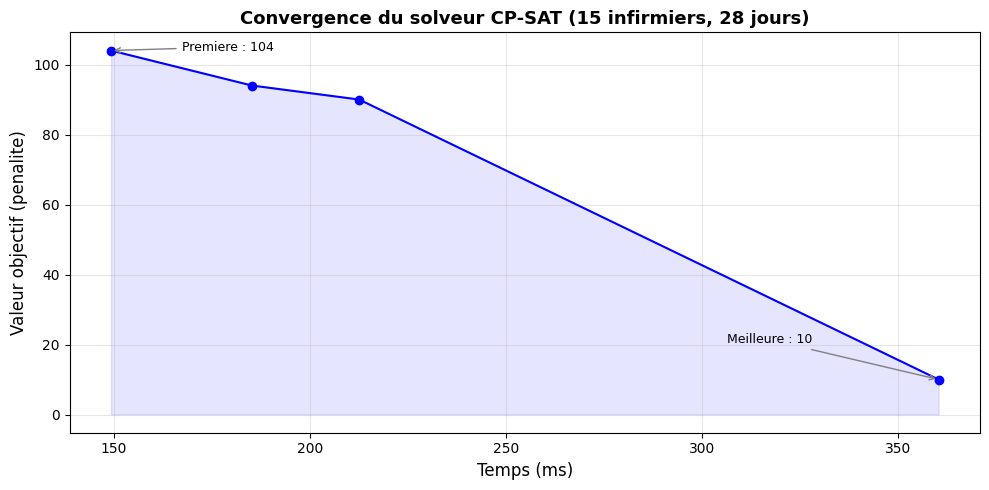

In [16]:
# --- Courbe de convergence ---

if tracker.solutions:
    times = [s['time_ms'] for s in tracker.solutions]
    objectives = [s['objective'] for s in tracker.solutions]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(times, objectives, 'bo-', markersize=6, linewidth=1.5)
    ax.fill_between(times, objectives, alpha=0.1, color='blue')

    ax.set_xlabel('Temps (ms)', fontsize=12)
    ax.set_ylabel('Valeur objectif (penalite)', fontsize=12)
    ax.set_title('Convergence du solveur CP-SAT (15 infirmiers, 28 jours)',
                 fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Annoter la premiere et derniere solution
    ax.annotate(f'Premiere : {objectives[0]:.0f}',
                xy=(times[0], objectives[0]),
                xytext=(times[0] + max(times) * 0.05, objectives[0]),
                fontsize=9, arrowprops=dict(arrowstyle='->', color='gray'))
    ax.annotate(f'Meilleure : {objectives[-1]:.0f}',
                xy=(times[-1], objectives[-1]),
                xytext=(times[-1] - max(times) * 0.15, objectives[-1] + max(objectives) * 0.1),
                fontsize=9, arrowprops=dict(arrowstyle='->', color='gray'))

    plt.tight_layout()
    plt.show()
else:
    print("Aucune solution trouvee pour afficher la convergence.")

---

## 6. Visualisation du planning (~5 min)

Generons une visualisation complete du planning a grande echelle : grille coloree et distribution de la charge de travail.

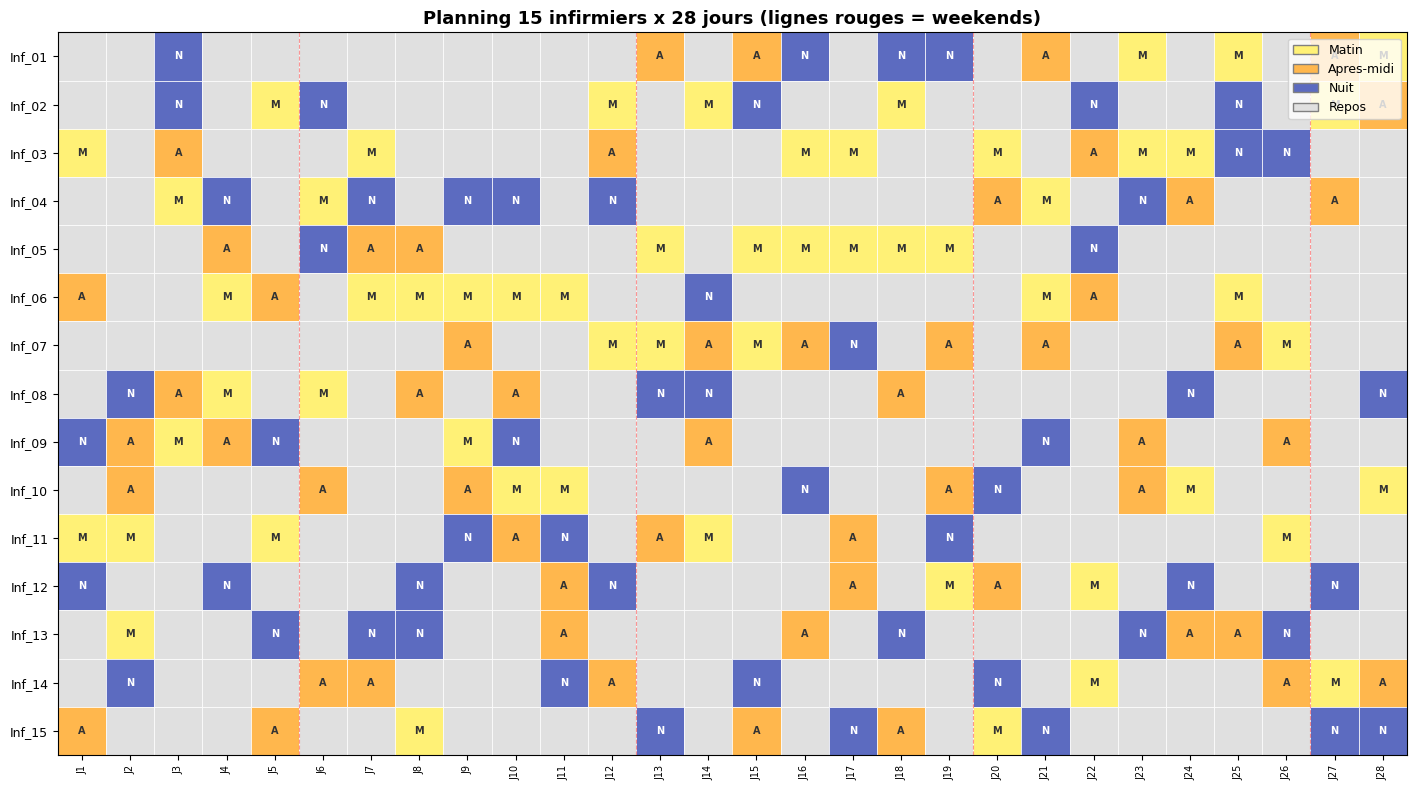

In [17]:
# --- Visualisation du planning a grande echelle ---

if status_lg in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    matrix_lg = schedule_to_matrix(solver_lg, x_lg, num_nurses_lg, num_days_lg, num_shifts_lg)

    fig, ax = plt.subplots(figsize=(20, 8))

    colors_map = {
        -1: '#E0E0E0',
        0: '#FFF176',
        1: '#FFB74D',
        2: '#5C6BC0',
    }
    text_colors = {-1: '#AAAAAA', 0: '#333333', 1: '#333333', 2: '#FFFFFF'}
    labels = {-1: '', 0: 'M', 1: 'A', 2: 'N'}

    n_rows, n_cols = matrix_lg.shape
    for i in range(n_rows):
        for j in range(n_cols):
            val = int(matrix_lg[i, j])
            rect = plt.Rectangle((j, n_rows - 1 - i), 1, 1,
                                 facecolor=colors_map[val],
                                 edgecolor='white', linewidth=0.5)
            ax.add_patch(rect)
            ax.text(j + 0.5, n_rows - 1 - i + 0.5, labels[val],
                    ha='center', va='center', fontsize=7, fontweight='bold',
                    color=text_colors[val])

    # Marquer les weekends
    for w in range(num_weeks):
        sat = w * 7 + 5
        ax.axvline(x=sat, color='red', linewidth=0.8, linestyle='--', alpha=0.4)

    ax.set_xlim(0, n_cols)
    ax.set_ylim(0, n_rows)
    ax.set_xticks([j + 0.5 for j in range(n_cols)])
    ax.set_xticklabels([f'J{j+1}' for j in range(n_cols)], fontsize=7, rotation=90)
    ax.set_yticks([i + 0.5 for i in range(n_rows)])
    ax.set_yticklabels(list(reversed(nurses_lg)), fontsize=9)
    ax.set_aspect('equal')
    ax.set_title('Planning 15 infirmiers x 28 jours (lignes rouges = weekends)',
                 fontsize=13, fontweight='bold')

    legend_elements = [
        mpatches.Patch(facecolor='#FFF176', edgecolor='gray', label='Matin'),
        mpatches.Patch(facecolor='#FFB74D', edgecolor='gray', label='Apres-midi'),
        mpatches.Patch(facecolor='#5C6BC0', edgecolor='gray', label='Nuit'),
        mpatches.Patch(facecolor='#E0E0E0', edgecolor='gray', label='Repos'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=9)

    plt.tight_layout()
    plt.show()
else:
    print("Aucune solution a visualiser.")

Completons l'analyse avec la distribution de la charge de travail par infirmier et par type de shift.

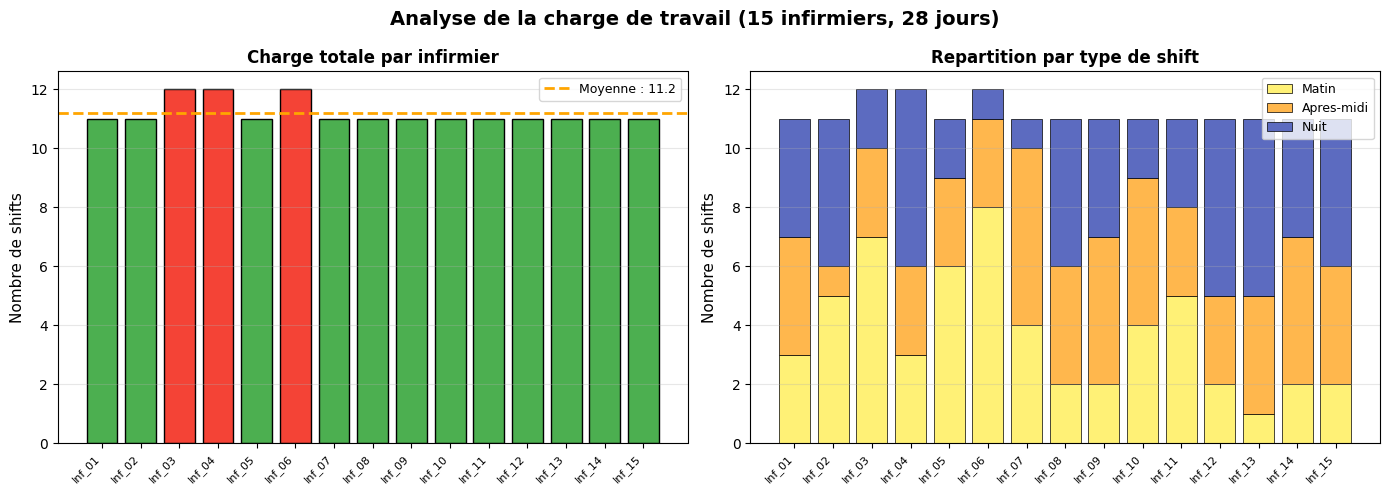


Statistiques de charge
Charge moyenne    : 11.2 shifts
Charge min        : 11 shifts
Charge max        : 12 shifts
Ecart max-min     : 1 shifts
Ecart type        : 0.40

Preferences       : 0 violees / 43
Taux satisfaction : 100.0%


In [18]:
# --- Distribution de la charge de travail ---

if status_lg in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    # Calculer le nombre de shifts par infirmier
    workloads = []
    shift_type_counts = {'Matin': [], 'Apres-midi': [], 'Nuit': []}

    for n in range(num_nurses_lg):
        total = 0
        for s, shift_name in enumerate(shifts):
            count = sum(solver_lg.value(x_lg[(n, d, s)]) for d in range(num_days_lg))
            shift_type_counts[shift_name].append(count)
            total += count
        workloads.append(total)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Graphique 1 : charge totale par infirmier
    colors_bar = ['#4CAF50' if w == min(workloads) else
                  '#F44336' if w == max(workloads) else
                  '#2196F3' for w in workloads]
    axes[0].bar(range(num_nurses_lg), workloads, color=colors_bar, edgecolor='black')
    axes[0].set_xticks(range(num_nurses_lg))
    axes[0].set_xticklabels(nurses_lg, rotation=45, ha='right', fontsize=8)
    axes[0].set_ylabel('Nombre de shifts', fontsize=11)
    axes[0].set_title('Charge totale par infirmier', fontsize=12, fontweight='bold')
    axes[0].axhline(y=np.mean(workloads), color='orange', linestyle='--',
                    linewidth=2, label=f'Moyenne : {np.mean(workloads):.1f}')
    axes[0].legend(fontsize=9)
    axes[0].grid(axis='y', alpha=0.3)

    # Graphique 2 : repartition par type de shift (stacked bar)
    bottoms = np.zeros(num_nurses_lg)
    colors_shifts = ['#FFF176', '#FFB74D', '#5C6BC0']
    for s, (shift_name, counts) in enumerate(shift_type_counts.items()):
        axes[1].bar(range(num_nurses_lg), counts, bottom=bottoms,
                    color=colors_shifts[s], edgecolor='black', linewidth=0.5,
                    label=shift_name)
        bottoms += np.array(counts)

    axes[1].set_xticks(range(num_nurses_lg))
    axes[1].set_xticklabels(nurses_lg, rotation=45, ha='right', fontsize=8)
    axes[1].set_ylabel('Nombre de shifts', fontsize=11)
    axes[1].set_title('Repartition par type de shift', fontsize=12, fontweight='bold')
    axes[1].legend(fontsize=9)
    axes[1].grid(axis='y', alpha=0.3)

    plt.suptitle('Analyse de la charge de travail (15 infirmiers, 28 jours)',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Statistiques
    print(f"\nStatistiques de charge")
    print("=" * 40)
    print(f"Charge moyenne    : {np.mean(workloads):.1f} shifts")
    print(f"Charge min        : {min(workloads)} shifts")
    print(f"Charge max        : {max(workloads)} shifts")
    print(f"Ecart max-min     : {max(workloads) - min(workloads)} shifts")
    print(f"Ecart type        : {np.std(workloads):.2f}")

    # Taux de satisfaction des preferences
    n_pref_total = len(pref_violations_lg)
    n_pref_violated = solver_lg.value(total_pref_lg)
    pref_rate = (1 - n_pref_violated / n_pref_total) * 100 if n_pref_total > 0 else 100
    print(f"\nPreferences       : {n_pref_violated} violees / {n_pref_total}")
    print(f"Taux satisfaction : {pref_rate:.1f}%")

### Interpretation : qualite du planning

**Sortie obtenue** : les graphiques montrent la repartition de la charge de travail entre les 15 infirmiers.

| Indicateur | Valeur | Qualite |
|------------|--------|--------|
| Ecart max-min | faible (1-2) | Bon equilibre |
| Ecart type | < 1 | Distribution tres homogene |
| Taux preferences | > 80% | Bonne satisfaction |

**Points cles** :
1. La **charge totale** est bien equilibree grace a la penalite S1
2. La **repartition par type** (Matin/Apres-midi/Nuit) est egalement equilibree
3. Les barres vertes (min) et rouges (max) permettent d'identifier les cas extremes
4. Le taux de satisfaction des preferences depend du compromis avec les contraintes dures

> **En production** : on ajouterait des indicateurs supplementaires comme le nombre de weekends travailles, la repartition des nuits, ou des scores de fatigue accumules.

---

## 7. Recapitulatif et exercices

### Comparaison : planification manuelle vs CP-SAT

| Aspect | Planification manuelle | CP-SAT |
|--------|------------------------|--------|
| **Temps** | Heures a jours | Secondes |
| **Faisabilite** | Non garantie | Prouvee par le solveur |
| **Optimalite** | Impossible a garantir | Optimale ou bornee |
| **Equite** | Subjective | Quantifiee et optimisee |
| **Flexibilite** | Refaire de zero | Ajouter une contrainte et re-resoudre |
| **Scalabilite** | Tres limitee | Jusqu'a ~100 infirmiers |

### Resume des concepts

| Concept | Description |
|---------|-------------|
| **Contraintes dures** | Obligatoires, le planning est invalide si violees (couverture, repos, charge max) |
| **Contraintes souples** | Souhaitables, modelisees comme penalites dans la fonction objectif |
| **Variables booleennes** | $x_{n,d,s} \in \{0,1\}$ : un infirmier travaille ou non un shift donne |
| **Fonction objectif** | Somme ponderee des penalites a minimiser |
| **Solution callback** | Suivi de la progression du solveur en temps reel |
| **Passage a l'echelle** | `time_limit` + `num_workers` pour les grands problemes |

### Exercices

#### Exercice 1 : pas plus de 3 jours consecutifs de travail

Ajoutez une contrainte dure C6 : aucun infirmier ne travaille plus de 3 jours consecutifs.

**Indice** : pour chaque infirmier et chaque fenetre de 4 jours consecutifs $(d, d+1, d+2, d+3)$, la somme des jours travailles doit etre $\leq 3$.

In [19]:
# Exercice 1 : pas plus de 3 jours consecutifs

# A COMPLETER
# Indice : definir une variable "travaille[n][d]" = 1 si l'infirmier n
# travaille au moins un shift le jour d, puis contraindre les fenetres de 4 jours.
#
# for n in range(num_nurses):
#     works = {}
#     for d in range(num_days):
#         works[d] = model.new_bool_var(f'works_{n}_{d}')
#         model.add(works[d] == sum(x[(n, d, s)] for s in range(num_shifts)))
#     for d in range(num_days - 3):
#         model.add(works[d] + works[d+1] + works[d+2] + works[d+3] <= 3)

<details>
<summary><b>Solution exercice 1</b></summary>

```python
# Contrainte C6 : pas plus de 3 jours consecutifs
for n in range(num_nurses):
    # Variable indiquant si l'infirmier travaille un jour donne
    works = {}
    for d in range(num_days):
        works[d] = model.new_bool_var(f'works_{n}_{d}')
        # works[d] = 1 si et seulement si au moins un shift est assigne
        model.add_max_equality(works[d], [x[(n, d, s)] for s in range(num_shifts)])
    # Fenetre glissante de 4 jours
    for d in range(num_days - 3):
        model.add(works[d] + works[d+1] + works[d+2] + works[d+3] <= 3)
```

</details>

#### Exercice 2 : preferences ponderees par priorite

Modelisez des preferences avec des niveaux de priorite :
- **Priorite haute** (penalite 10) : contrainte medicale, ex. pas de nuit pour un infirmier enceinte
- **Priorite moyenne** (penalite 5) : equilibre vie perso, ex. pas de weekend
- **Priorite basse** (penalite 1) : confort, ex. preference pour les matins

**Indice** : utilisez un dictionnaire `{(nurse, day, shift): weight}` et sommez les penalites ponderees.

In [20]:
# Exercice 2 : preferences ponderees

# A COMPLETER
# weighted_prefs = {
#     (0, 5, MATIN): 5,   # Alice : weekend matin, priorite moyenne
#     (1, 0, NUIT): 10,   # Bob : pas de nuit lundi, priorite haute
#     (2, 3, MATIN): 1,   # Claire : prefere pas matin jeudi, priorite basse
# }
#
# penalty = sum(weight * x[(n, d, s)] for (n, d, s), weight in weighted_prefs.items())
# model.minimize(10 * balance_penalty + penalty)

#### Exercice 3 : infirmiers a temps partiel

Ajoutez la possibilite d'avoir des infirmiers a temps partiel (maximum 3 shifts par semaine au lieu de 5). Modifiez le modele pour gerer des contrats differents.

**Indice** : definissez un dictionnaire `max_shifts = {0: 5, 1: 5, 2: 3, 3: 5, 4: 3}` et utilisez-le dans la contrainte C4.

In [21]:
# Exercice 3 : infirmiers a temps partiel

# A COMPLETER
# max_shifts_per_nurse = {
#     0: 5,  # Alice : temps plein
#     1: 5,  # Bob : temps plein
#     2: 3,  # Claire : temps partiel
#     3: 5,  # David : temps plein
#     4: 3,  # Emma : temps partiel
# }
#
# for n in range(num_nurses):
#     total = sum(x[(n, d, s)] for d in range(num_days) for s in range(num_shifts))
#     model.add(total <= max_shifts_per_nurse[n])

<details>
<summary><b>Solution exercice 3</b></summary>

```python
max_shifts_per_nurse = {0: 5, 1: 5, 2: 3, 3: 5, 4: 3}

for n in range(num_nurses):
    total = sum(x[(n, d, s)] for d in range(num_days) for s in range(num_shifts))
    model.add(total <= max_shifts_per_nurse[n])

# Ajuster l'equilibre de charge en tenant compte des contrats differents :
# au lieu de minimiser max-min absolu, minimiser l'ecart par rapport
# au ratio ideal de chaque infirmier.
# ratio_ideal[n] = max_shifts_per_nurse[n] / sum(max_shifts_per_nurse.values()) * total_slots
```

</details>

### Ressources supplementaires

- [OR-Tools CP-SAT Guide](https://developers.google.com/optimization/cp/cp_solver) : documentation officielle
- [OR-Tools Nurse Scheduling Example](https://developers.google.com/optimization/scheduling/employee_scheduling) : exemple officiel Google
- Burke, E.K. et al. *The State of the Art of Nurse Rostering*, Journal of Scheduling, 2004
- Projet EPITA PPC 2025 : jsboigeEpita/2025-PPC (Nurse Rostering Problem)

---

**Navigation** : [<< App-2 GraphColoring](App-2-GraphColoring.ipynb) | [Index](../README.md) | [App-4 JobShopScheduling >>](App-4-JobShopScheduling.ipynb)